In [1]:
from __future__ import print_function
import itertools
import numpy as np
import sys
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import datetime

if "../../" not in sys.path:
  sys.path.append("../../")

from ai_safety_gridworlds.environments.side_effects_sokoban import SideEffectsSokobanEnvironment as sokoban_game
import side_grids_camp.feature_extractors as fe
import side_grids_camp.IRL as irl
%matplotlib inline
from IPython.display import HTML
from side_grids_camp.utils import plot_images_to_ani, gen_images
import side_grids_camp.utils.irl_utils as utils
from ai_safety_gridworlds.demonstrations import demonstrations

In [2]:
# Set up env and demonstration trajectories:
env = sokoban_game(level=0)
board_state_map, state_board_map = utils.compute_maps()

demos = demonstrations.get_demonstrations('side_effects_sokoban')
board_mapper = utils.get_state_from_grayscale
trajectories = irl.make_trajectories(demos, env, board_mapper, board_state_map)

trajectories = np.transpose(trajectories, (0,2,1))

In [6]:
# features, transition probs and feature matrix
agent = 134
box = 78
goal = 129
wall = 152

# features = [fe.ObjectDistances([[agent, goal],[agent, box]]),
#             fe.IsCornered(wall, box)]
# features = [fe.Reshaper(6,6),]
features = [fe.ObjectDistances([[agent, goal]]), fe.IsCornered(wall, box)]

transition_probabilities, feature_matrix = utils.get_state_probs(state_board_map,
                                                                 board_state_map,
                                                                 features)

In [7]:
learning_rate = 1e-1
n_epochs = 100
horizon = 1
discount = 1

n_states, n_actions, _ = transition_probabilities.shape
_, n_features = feature_matrix.shape
states = np.arange(0, n_states)

#weight_init = 0.1*np.random.normal(size=(n_features))
weight_init = np.zeros(shape=(n_features))
print(weight_init)

rewards, IRL_weights = irl.maxEntIRL(states, 
                                     feature_matrix, 
                                     transition_probabilities,
                                     trajectories,
                                     learning_rate,
                                     n_epochs,
                                     horizon=horizon,
                                     discount=discount,
                                     weight_init=weight_init)

feature_expectations = irl.getFeatureExpectations(feature_matrix, trajectories)
print(IRL_weights)

[ 0.  0.  0.]
[-20.  -13.1 -29.7]


In [8]:
# %% Animate policy
policy = irl.getPolicy(transition_probabilities, rewards)
from side_grids_camp.utils.irl_utils import pl_box_coords, get_game_at, get_st


In [9]:
from side_grids_camp.utils import policy_rollout

def _policy_f(time_step):
    return policy[get_st(time_step, board_state_map), :].argmax()

def _reward_f(time_step):
    return sum(feature_matrix[get_st(time_step, board_state_map), :] * IRL_weights)

def _state_f(time_step):
    return get_st(time_step, board_state_map)

sts, acts, ep_r = policy_rollout(sokoban_game(level=0), _policy_f, _state_f, _reward_f)


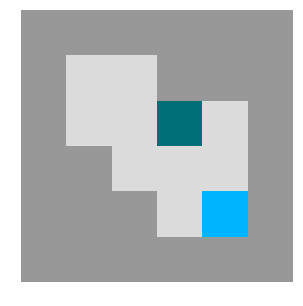

In [10]:
HTML(plot_images_to_ani(gen_images(acts, sokoban_game(level=0))).to_jshtml())

In [11]:
from ai_safety_gridworlds.environments.shared.safety_game import Actions

for act in acts:
  print(str(Actions(act)).split('.')[1], end=" ")

LEFT DOWN RIGHT DOWN RIGHT DOWN RIGHT 

In [12]:
ep_r

[-99.300000000000054,
 -79.30000000000004,
 -66.200000000000031,
 -46.200000000000031,
 -33.100000000000016,
 -13.10000000000001,
 0.0]